In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CSV Reader") \
    .getOrCreate()
df = spark.read.csv("/content/housing.csv", header=True, inferSchema=True)
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [ ]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



**Boş değerlerin yüzdelik olarak gösterimi**

In [ ]:
for column in df.columns:
    total_count = df.count()
    null_count = df.filter(col(column).isNull()).count()
    null_ratio = null_count / total_count

    print(f"{column} Boş değerlerin oranı: {null_ratio:.2%}")


longitude Boş değerlerin oranı: 0.00%
latitude Boş değerlerin oranı: 0.00%
housing_median_age Boş değerlerin oranı: 0.00%
total_rooms Boş değerlerin oranı: 0.00%
total_bedrooms Boş değerlerin oranı: 1.00%
population Boş değerlerin oranı: 0.00%
households Boş değerlerin oranı: 0.00%
median_income Boş değerlerin oranı: 0.00%
median_house_value Boş değerlerin oranı: 0.00%
ocean_proximity Boş değerlerin oranı: 0.00%


**Sadece total_rooms sütunu boş değer içeriyor. %1 boş değer çok küçük bir değer olduğu için boş değerleri kaldırmayı tercih edildi**

In [ ]:
df = df.na.drop()
print(df.filter(col('total_bedrooms').isNull()).count())

0


**Scatter grafiği ile ev fiyatlarının enlem ve boylam yani konuma göre dağılım grafiğini çizdiririz. Buradan fiyatın belirli bölgelerde daha yüksek olduğu çıkarımı yapılabilir.**

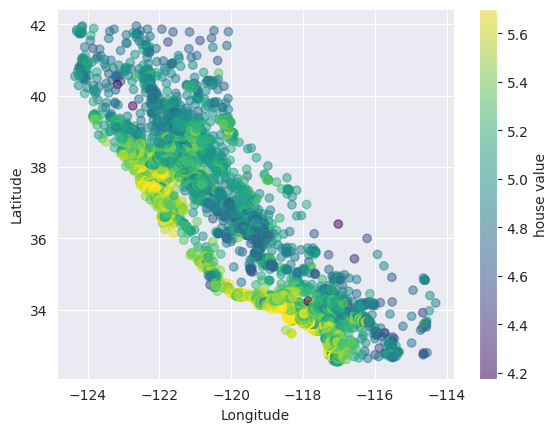

In [ ]:
import matplotlib.pyplot as plt

df_pd = df.select('longitude', 'latitude', 'median_house_value','population').toPandas()

plt.scatter(df_pd['longitude'], df_pd['latitude'], c=np.log10(df_pd['median_house_value']),
            cmap='viridis', linewidth=1, alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='house value')
plt.show()


**Bar plot sayesinde denize yakkınlık durumunun ortalama fiyat üzerinde etkisini gözlemleyebiliyoruz.**

<Axes: xlabel='ocean_proximity', ylabel='avg(median_house_value)'>

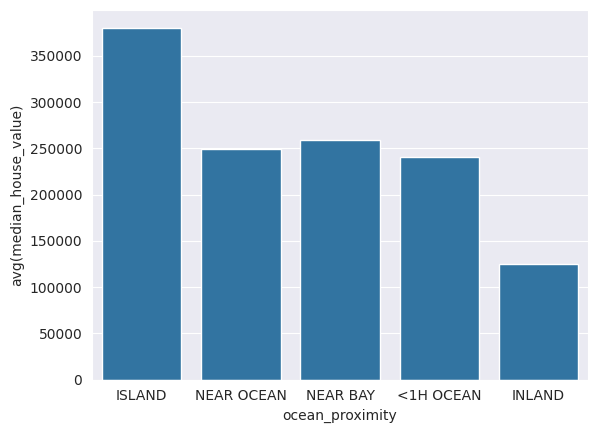

In [ ]:
import seaborn as sns
df_i = df.groupby('ocean_proximity').agg({'median_house_value' : 'avg'})
df_p = df_i.toPandas()
sns.barplot(x = df_p['ocean_proximity'], y = df_p['avg(median_house_value)'])


*   ocean_proximity sütununu çıkararak yeni bir data frame oluşturdum. Bu veriyi kullanarak korelasyon matrisi çizdirdim.


*   korelasyon matrisine bakarsak total_rooms, total_bedrooms, population, households yüksek kolerasyona sahip. Bu yüzden Feature Selection yapmamız lazım. Bu nedenle bu sütunlardan sadeec total_rooms özelliğini seçiyoruz.
Çünkü oda sayısı bir evin fiyatını belirlemede diğer özelliklere göre daha önemlidir.





<Axes: >

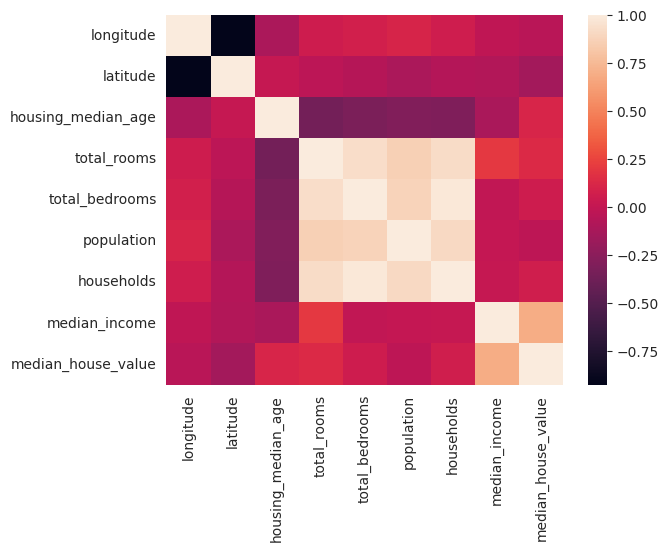

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import numpy as np
import pandas as pd
selected_columns = [col_name for col_name in df.columns if col_name != 'ocean_proximity' ]

df_selected = df.select(selected_columns)

assembler = VectorAssembler(inputCols=df_selected.columns, outputCol="features")
df_vector = assembler.transform(df_selected).select("features")

matrix = Correlation.corr(df_vector, 'features')
corrmatrix = matrix.collect()[0][0].toArray().tolist()

df_corr = pd.DataFrame(corrmatrix, columns = df_selected.columns, index = df_selected.columns)

sns.heatmap(df_corr)

In [ ]:
df2 = df.select(['longitude','latitude','housing_median_age','total_rooms','median_income','ocean_proximity','median_house_value'])
df2.show()

+---------+--------+------------------+-----------+-------------+---------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|median_income|ocean_proximity|median_house_value|
+---------+--------+------------------+-----------+-------------+---------------+------------------+
|  -122.23|   37.88|              41.0|      880.0|       8.3252|       NEAR BAY|          452600.0|
|  -122.22|   37.86|              21.0|     7099.0|       8.3014|       NEAR BAY|          358500.0|
|  -122.24|   37.85|              52.0|     1467.0|       7.2574|       NEAR BAY|          352100.0|
|  -122.25|   37.85|              52.0|     1274.0|       5.6431|       NEAR BAY|          341300.0|
|  -122.25|   37.85|              52.0|     1627.0|       3.8462|       NEAR BAY|          342200.0|
|  -122.25|   37.85|              52.0|      919.0|       4.0368|       NEAR BAY|          269700.0|
|  -122.25|   37.84|              52.0|     2535.0|       3.6591|       NEAR BAY|          

Outliers tespiti yaptığımızda total_rooms ve median_income sütunlarında max uç noktalarda outliers olduğunu söyleyebiliriz.

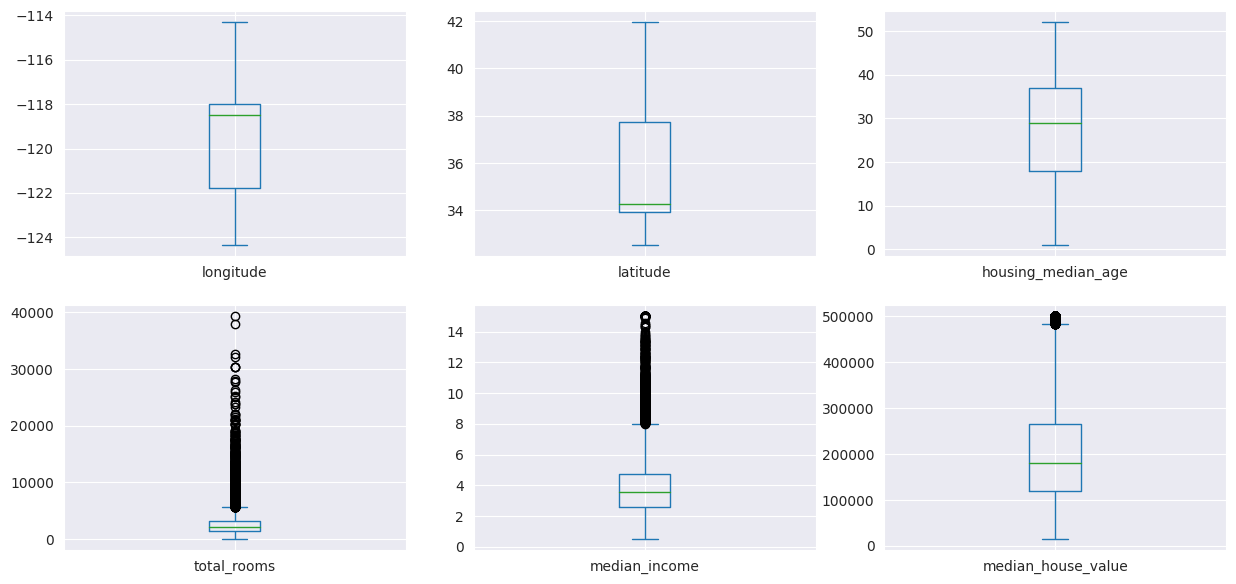

In [ ]:
import matplotlib.pyplot as plt

df_pd = df2.toPandas()
df_pd.plot(kind='box', subplots=True, layout=(2, 3), figsize=(15, 7))
plt.show()


**Bu kod, bir sütunun belirli bir yüzdelik dilimine göre filtrelenmesini gerçekleştirir. Bu işlem veri setindeki aşırı değerleri eleme amacıyla kullanılmıştır.**

In [ ]:
from pyspark.sql.functions import expr

total_rooms_quantile = df2.approxQuantile("total_rooms", [0.9], 0.001)[0]
median_income_quantile = df2.approxQuantile("median_income", [0.9], 0.001)[0]

df2 = df2.filter(expr(f"total_rooms < {total_rooms_quantile}"))
df2 = df2.filter(expr(f"median_income < {median_income_quantile}"))


**Sayısal değerlerin histogram grafiği ile dağılımlarını gözlemledim. Bütün sütunlar normal dağılıma yakın olduğunu söyleyebiliriz**

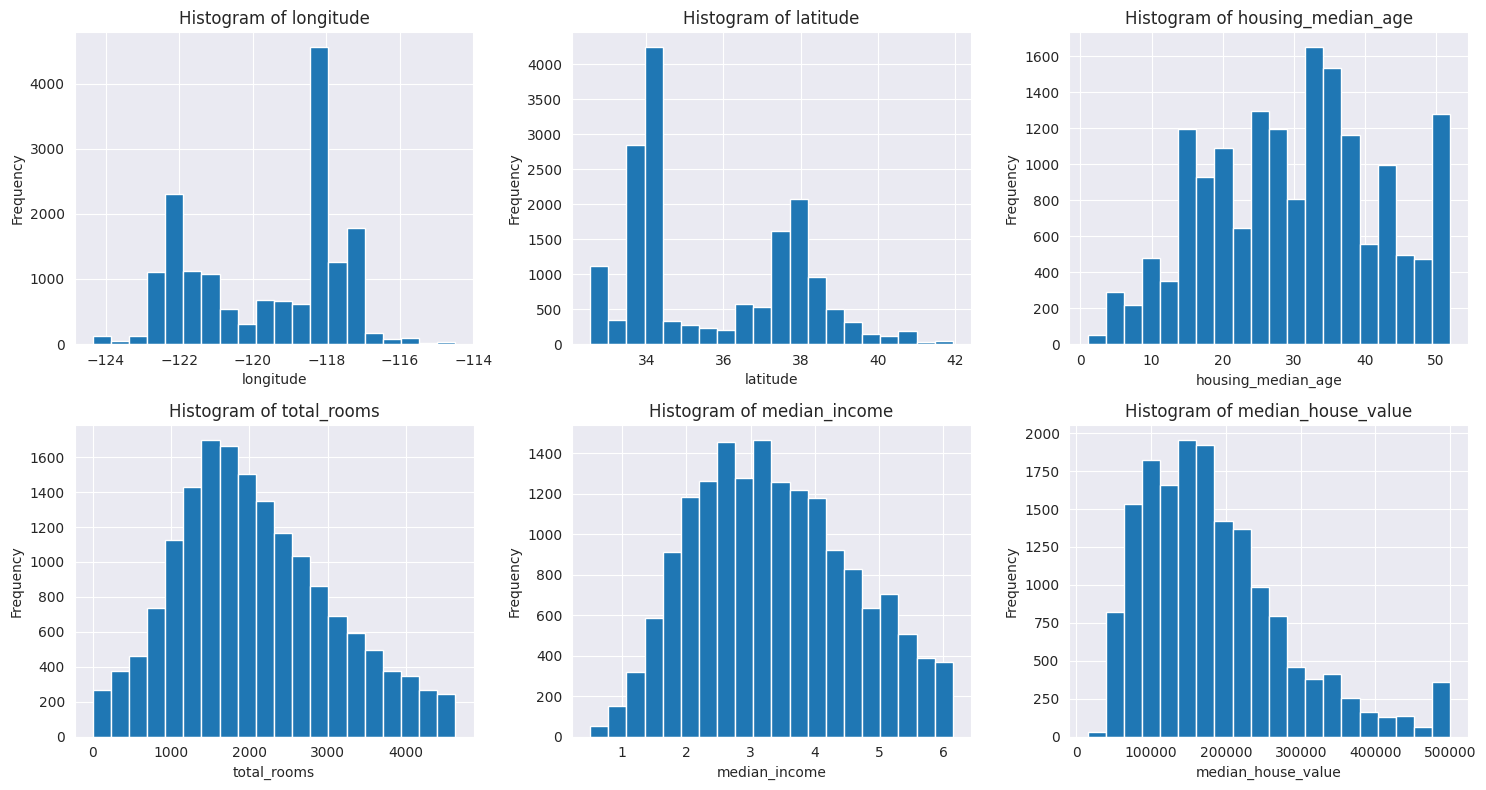

In [ ]:
df3 = df2.select(['longitude','latitude','housing_median_age','total_rooms','median_income','median_house_value'])

def hist_plots(df, variables):
    num_plots = len(variables)
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, var in enumerate(variables):
        df.select(var).toPandas().hist(ax=axes[i], bins=20)
        axes[i].set_title(f'Histogram of {var}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Frequency')


    plt.tight_layout()
    plt.show()


hist_plots(df3, df3.columns)


In [ ]:
df2 = df2.withColumnRenamed("median_house_value", "label")

df_train, df_test = df2.randomSplit([0.75, 0.25])
print("Training Rows:", df_train.count(), " Testing Rows:", df_test.count())


Training Rows: 12559  Testing Rows: 4123



  **Oluşturulan pipeline adımları**
*   Ocean_proximity kategorik verisini op_index sayısal veriye çevirildi.
*   VectorAssembler ile özellikleri tek bir vektörde birleştirildi.
*   Scaling işlemi uygulandı
*   RandomForestRegresor tercih edildi.





In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor

indexer = StringIndexer(inputCol="ocean_proximity", outputCol="op_index")

assembler = VectorAssembler(inputCols=["longitude", "latitude", "housing_median_age", "op_index", "total_rooms", "median_income"], outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)


rf = RandomForestRegressor(labelCol="label", featuresCol="scaledFeatures")

pipeline = Pipeline(stages=[indexer, assembler, scaler , rf])


**Cross-Validation yöntemini kullanılarak bir makine öğrenimi modelini eğitmek ve doğrulamak için kullanılır.**

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 5, stop = 20, num = 5)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 20, num = 5)]) \
    .build()

from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)



**CrossValidator'u kullanarak veri kümesi üzerinde eğitim yapar.**

In [ ]:
cvModel = crossval.fit(df_train)


Test verisi üzerinden RegressionEvaluator kullanlarak modelin performansı değerlendilir.

En sonda baştaki veri setimizi test için kullanılır.

In [ ]:
predictions = cvModel.transform(df_test)

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

rfPred = cvModel.transform(df2)


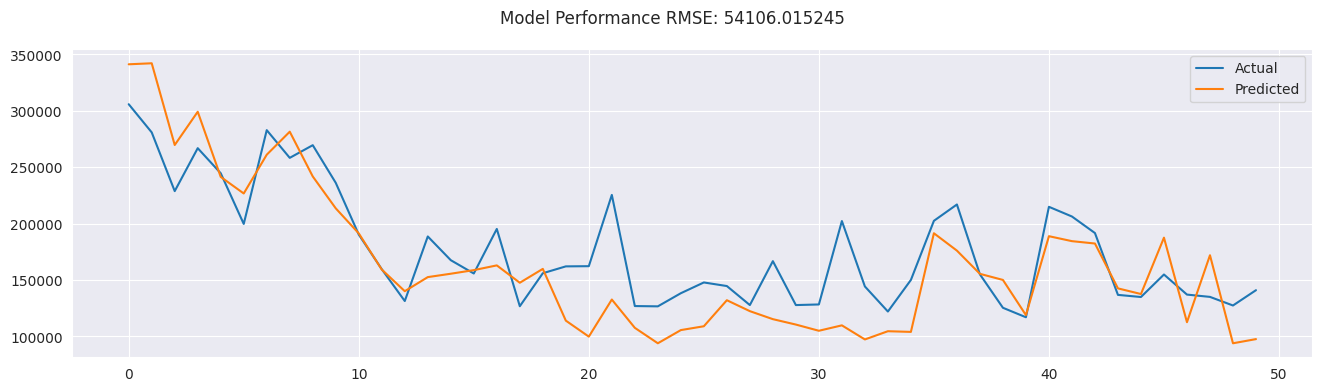

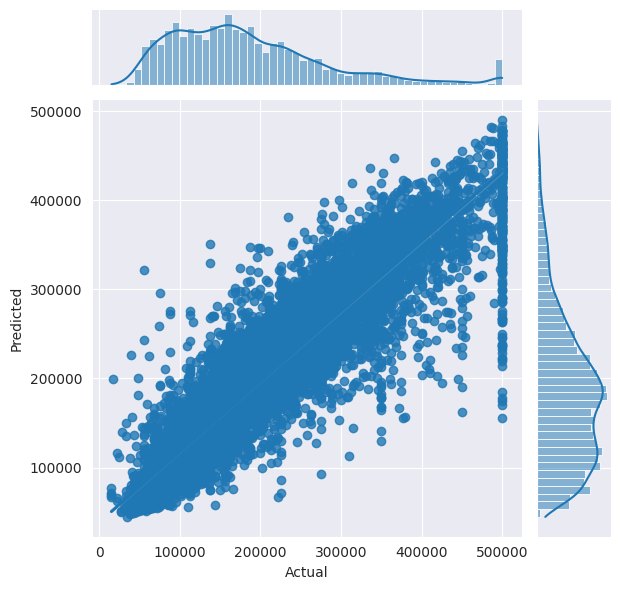

In [ ]:
rfResult = rfPred.toPandas()
test = pd.DataFrame({'Predicted':rfResult.prediction,'Actual':rfResult.label})
fig= plt.figure(figsize=(16,4))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind="reg")